In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
%matplotlib inline
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets,transforms
import matplotlib.image as mpimg

In [3]:
transformation=transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_ds=datasets.MNIST(
    'data/',
    train=True,
    transform=transformation,
    download=True
)

In [5]:
text_ds=datasets.MNIST(
    'data/',
    train=False,
    transform=transformation,
    download=True
)

In [6]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True)
text_dl=DataLoader(text_ds,batch_size=256)

In [69]:
imgs,label=next(iter(train_dl))

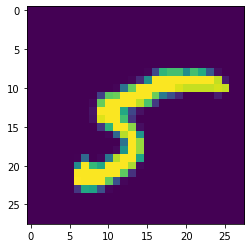

In [70]:
plt.imshow(np.squeeze(imgs[0].numpy()))

In [9]:
label

tensor([8, 7, 3, 4, 8, 1, 6, 1, 7, 8, 2, 1, 9, 8, 6, 7, 4, 1, 1, 8, 1, 5, 3, 6,
        2, 8, 1, 3, 0, 7, 3, 8, 8, 6, 5, 3, 5, 3, 9, 1, 3, 2, 8, 0, 4, 7, 3, 7,
        7, 1, 9, 0, 5, 4, 5, 8, 5, 9, 7, 3, 8, 4, 3, 3])

In [7]:
def imshow(image):
    img=image.numpy()
    img=np.squeeze(img)
    plt.imshow(img)

In [12]:
imgs[0].shape

torch.Size([1, 28, 28])

In [8]:
plt.figure(figsize=(10,1))
for i,img in enumerate(imgs[:10]):
    plt.subplot(1,10,i+1)
    imshow(img)
    plt.title(label[i].item())

NameError: name 'imgs' is not defined

<Figure size 720x72 with 0 Axes>

In [98]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1=nn.Conv2d(1,6,5)
        self.pool=nn.MaxPool2d((2,2))
        self.conv_2=nn.Conv2d(6,16,5)
        self.linear1=nn.Linear(16*4*4,256)
        self.linear2=nn.Linear(256,10)
    def forward(self,input):
        x=F.relu(self.conv_1(input))
        x=self.pool(x)
        x=F.relu(self.conv_2(x))
        x=self.pool(x)
        #print(x.size())  torch.Size([64, 16, 4, 4])
        x=x.view(-1,16*4*4)
        x=F.relu(self.linear1(x))
        x=self.linear2(x)
        return x

In [107]:
model(imgs[1])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 1, 5, 5], but got 3-dimensional input of size [1, 28, 28] instead

In [124]:
loss_fn=nn.CrossEntropyLoss()
model=Model()

In [125]:
opt=torch.optim.Adam(model.parameters(),lr=0.01)

In [126]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0                              #总样本的个数
    running_loss=0
    for x,y in trainloader:    
        y_pred=model(x)
        loss=loss_fn(y_pred,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():                  #每一个y值进行一次计算，这是对训练数据
            y_pred=torch.argmax(y_pred,dim=1)
            correct+=(y_pred==y).sum().item()  #每一次正确的个数加到correct里
            total+=y.size(0)                   #每一批样本的个数
            running_loss+=loss.item()          #每一批样本的loss
        
        epoch_acc=correct/total                #正确率为正确个数除以样本个数
        epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
        
        
        text_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
        text_total=0                              
        text_running_loss=0
        with torch.no_grad():                  
             for x,y in textloader:    
                y_pred=model(x)
                loss=loss_fn(y_pred,y)
                y_pred=torch.argmax(y_pred,dim=1)
                text_correct+=(y_pred==y).sum().item() 
                text_total+=y.size(0)                   
                text_running_loss+=loss.item()
        
        epoch_text_acc=text_correct/text_total                
        epoch_text_loss=running_loss/len(textloader.dataset)  
        
        print('epoch: ',epoch,'loss: ',round(epoch_loss,3),
                              'accuracy: ',round(epoch_acc,3),
                              'text_loss: ',round(epoch_text_loss,3),
                              'text_accuracy: ',round(epoch_text_acc,3))
        return epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc  
                                                    #这样就会将每个epoch上的这些平均正确率和平均损失返回

In [127]:
train_acc=[]
train_loss=[]
text_acc=[]
text_loss=[]

In [128]:
for epoch in range(50):
    epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc=fit(epoch,model,train_dl,text_dl)
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    text_acc.append(epoch_text_acc)
    text_loss.append(epoch_text_loss)

epoch:  0 loss:  0.0 accuracy:  0.125 text_loss:  0.0 text_accuracy:  0.117
epoch:  1 loss:  0.0 accuracy:  0.094 text_loss:  0.0 text_accuracy:  0.125
epoch:  2 loss:  0.0 accuracy:  0.109 text_loss:  0.0 text_accuracy:  0.099
epoch:  3 loss:  0.0 accuracy:  0.094 text_loss:  0.0 text_accuracy:  0.125
epoch:  4 loss:  0.0 accuracy:  0.188 text_loss:  0.0 text_accuracy:  0.203
epoch:  5 loss:  0.0 accuracy:  0.125 text_loss:  0.0 text_accuracy:  0.264
epoch:  6 loss:  0.0 accuracy:  0.219 text_loss:  0.0 text_accuracy:  0.374
epoch:  7 loss:  0.0 accuracy:  0.375 text_loss:  0.0 text_accuracy:  0.434
epoch:  8 loss:  0.0 accuracy:  0.422 text_loss:  0.0 text_accuracy:  0.508
epoch:  9 loss:  0.0 accuracy:  0.484 text_loss:  0.0 text_accuracy:  0.455
epoch:  10 loss:  0.0 accuracy:  0.391 text_loss:  0.0 text_accuracy:  0.433
epoch:  11 loss:  0.0 accuracy:  0.453 text_loss:  0.0 text_accuracy:  0.643
epoch:  12 loss:  0.0 accuracy:  0.609 text_loss:  0.0 text_accuracy:  0.653
epoch:  1

In [85]:
imgs[0].size(),imgs[0].size(0),imgs[0].size(1),imgs[0].size(2)

(torch.Size([1, 28, 28]), 1, 28, 28)

In [86]:
x=img[0].view(-1,imgs[0].size(1)*imgs[0].size(2))

In [95]:
y=img[0].view(imgs[0].size(0),-1)

In [96]:
x.size(),y.size()

(torch.Size([784, 1]), torch.Size([1, 784]))

In [97]:
imgs[0].size(0)

1

Text(0.5, 1.0, 'acc')

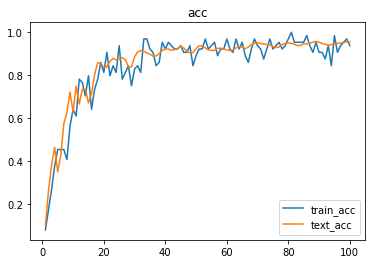

In [63]:
plt.plot(range(1,101),train_acc[100:200],label='train_acc')
plt.plot(range(1,101),text_acc[100:200],label='text_acc')
plt.legend()
plt.title('acc')

Text(0.5, 1.0, 'loss')

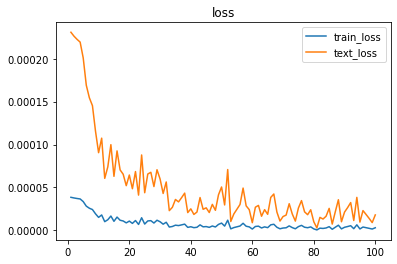

In [65]:
plt.plot(range(1,101),train_loss[100:200],label='train_loss')
plt.plot(range(1,101),text_loss[100:200],label='text_loss')
plt.legend()
plt.title('loss')

In [129]:
torch.argmax(model(imgs),1)

tensor([5, 4, 9, 9, 2, 8, 2, 4, 1, 8, 2, 7, 8, 3, 7, 7, 0, 5, 7, 9, 1, 9, 2, 2,
        9, 3, 7, 0, 7, 1, 3, 0, 1, 7, 1, 6, 6, 8, 4, 0, 5, 0, 5, 5, 8, 7, 8, 8,
        7, 3, 3, 9, 7, 9, 2, 0, 8, 9, 9, 4, 7, 8, 2, 6])

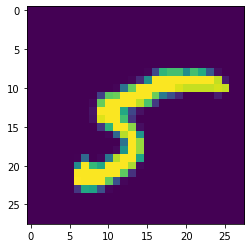

In [80]:
imshow(imgs[0])

In [130]:
images,labels=next(iter(text_dl))

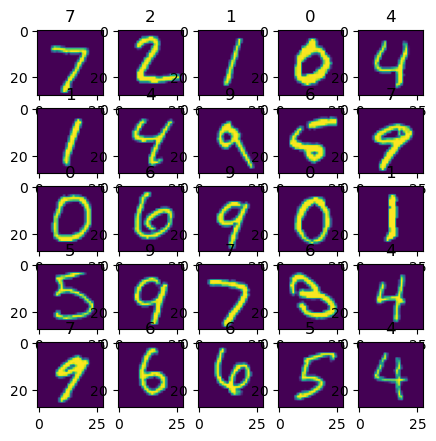

In [136]:
plt.figure(figsize=(5,5),dpi=100)
for i,img in enumerate(images[:25]):
    plt.subplot(5,5,i+1)
    imshow(img)
    plt.title(torch.argmax(model(images),1)[i].item())

In [57]:
labels[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [111]:
model(imgs).shape

torch.Size([64, 10])

In [120]:
torch.argmax(model(imgs),1)[0]

tensor(1)

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv('Income1.csv')

In [18]:
data.size,data.shape,data.Education.values[1].dtype

(90, (30, 3), dtype('float64'))

In [33]:
np.unique(data.Education.values)

array([10.        , 10.40133779, 10.84280936, 11.24414716, 11.64548495,
       12.08695652, 12.48829431, 12.88963211, 13.2909699 , 13.73244147,
       14.13377926, 14.53511706, 14.97658863, 15.37792642, 15.77926421,
       16.22073579, 16.62207358, 17.02341137, 17.46488294, 17.86622074,
       18.26755853, 18.7090301 , 19.11036789, 19.51170569, 19.91304348,
       20.35451505, 20.75585284, 21.15719064, 21.59866221, 22.        ])

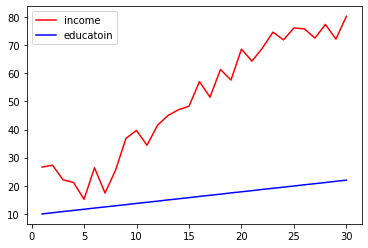

In [44]:
plt.plot(range(1,31),data.Income,c='r',label='income')
plt.plot(range(1,31),data.Education,c='b',label='educatoin')
plt.legend()
plt.show()

In [96]:
data=pd.read_csv('HR.csv')

In [89]:
data.part.unique(),data.salary.unique()

(array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
        'IT', 'product_mng', 'marketing', 'RandD'], dtype=object),
 array(['low', 'medium', 'high'], dtype=object))

In [97]:
data=data.join(pd.get_dummies(data['salary']))
del data['salary']

In [100]:
data=data.join(pd.get_dummies(data['part']))

In [102]:
del data['part']

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   high                   14999 non-null  uint8  
 9   low                    14999 non-null  uint8  
 10  medium                 14999 non-null  uint8  
 11  IT                     14999 non-null  uint8  
 12  RandD                  14999 non-null  uint8  
 13  accounting             14999 non-null  uint8  
 14  hr                     14999 non-null  uint8  
 15  ma

In [105]:
data=pd.read_csv('iris.csv')

In [106]:
data

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,virginica
146,147,6.3,2.5,5.0,1.9,virginica
147,148,6.5,3.0,5.2,2.0,virginica
148,149,6.2,3.4,5.4,2.3,virginica


In [110]:
pd.factorize(data.Species)[0],pd.factorize(data.Species),pd.factorize(data.Species)[1]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2,

In [111]:
data.Species=pd.factorize(data.Species)[0]

In [112]:
data

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [113]:
from torch import nn

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    150 non-null    int64  
 1   Sepal.Length  150 non-null    float64
 2   Sepal.Width   150 non-null    float64
 3   Petal.Length  150 non-null    float64
 4   Petal.Width   150 non-null    float64
 5   Species       150 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 7.2 KB


In [117]:
data.Species.value_counts()

0    50
1    50
2    50
Name: Species, dtype: int64

In [118]:
import torch.nn.functional as F

In [120]:
from torch.utils.data import TensorDataset,dataloader

In [122]:
a=torch.randn(2,3,4)

In [123]:
a

tensor([[[-0.3336,  1.9816, -0.5873,  0.0449],
         [ 0.9726, -0.5409, -1.5825,  0.7096],
         [ 0.1422, -0.2093, -0.0669, -0.5183]],

        [[ 0.2272, -2.4761, -0.5570,  1.5483],
         [ 0.8505,  0.3689, -0.1086,  0.1798],
         [-0.6649,  0.2963,  0.2561, -0.2980]]])

In [127]:
a.argmax(dim=0),a.argmax(dim=1),a.argmax(dim=2)

(tensor([[1, 0, 1, 1],
         [0, 1, 1, 0],
         [0, 1, 1, 1]]),
 tensor([[1, 0, 2, 1],
         [1, 1, 2, 0]]),
 tensor([[1, 0, 0],
         [3, 0, 1]]))

In [133]:
b=torch.randn(4,3)

In [134]:
b

tensor([[-0.3388, -0.6538, -0.2194],
        [ 1.3076, -0.8827,  0.1513],
        [-0.4168,  0.6212, -0.9612],
        [-1.1301, -0.0318,  1.0028]])

In [135]:
torch.argmax(b,dim=0)

tensor([1, 2, 3])

In [13]:
from torch.utils.data import TensorDataset,DataLoader
from torch.utils import data
import torch
from PIL import Image

In [12]:
class Mydataset(data.Dataset):
    def __init__(self,root):
        self.imgs_path=root
    def __getitem__(self,index):
        img_path=self.imgs_path[index]
        return img_path
    def __len__(self):
        return len(self.imgs_path)

In [14]:
class Mydataset(data.Dataset):
    def __init__(self,root,label,transform):
        self.img_path=root
        self.label=label
        self.transform=transform
    def __getitem__(self,index):
        img=self.imgs[index]
        label=self.label[index]
        pil_img=Image.open(img)
        data=self.transform(pil_img)
        return data,label
    def __len__(self):
        return len(self.img_path)
